# Modélisation des populations avec le système de Hastings-Powell

Le système de Hastings-Powell est un modèle mathématique qui sert à décrire l'évolution des effectifs de trois populations X,Y et Z, telles que X soit la proie de Y, qui est elle la proie de Z. Le système différentiel, après adimensionalisation, est:
\
\
$$
  \begin{array}{rcr}
    \frac{dx}{dt} & = & x(1-x) - f_y(x) y\\
    \frac{dy}{dt} & = & f_y(x) y - f_z(y) z - d_y y\\
    \frac{dz}{dt} & = & f_z(y) z - d_z z 
  \end{array}
$$

Dans ce notebook, on détaillera le programme mis en place pour résoudre numériquement ce système, et pour étudier son comportement lorsqu'on varie les valeurs des paramètres.

## I. Les Bibliothéques et les fonctions

Tout d'abord, il faut appeler les bilbliothéques qu'on va utiliser pour écrire le programme:

In [9]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
from math import sqrt
from numpy import linspace

```matplotlib```nous permettra de tracer des figures,
\
```axes3d``` nous permettra de tracer les trajectoires de phase dy système,
\
```sqrt``` sera utilisée pour comparée les résulats avec les valeurs réelles (on calculera le conefficient de corrélation).

## II. Les valeurs des paramètres

Il faut ensuite fixer les valeurs des paramètres $a_x, a_y, b_x, b_y, d_y$ et $d_z$:

In [10]:
a_x, a_y, b_x, b_y, d_y, d_z = 5.0, 0.1, 2.9, 2.0, 0.4, 0.011

On introduit aussi les fonctions de Holling d'espèce II qui sont $f_y$ et $f_z$:

In [11]:
def holling(u, a, b):
    return((a*u)/(1+b*u))

## III. Ecriture du système

On définit dans cette partie la fonction ```système```qui régit notre système différentiel:

In [12]:
def système(x, y, z, b_x, t):
    return x*(1-x)-holling(x,a_x,b_x)*y, holling(x,a_x,b_x)*y-holling(y,a_y,b_y)*z-d_y*y, holling(y,a_y,b_y)*z-d_z*z

Elle prend en entrée $x(t), y(t), z(t)$ et $t$, et elle renvoie en sortie $x'(t), y'(t), z'(t)$
\
En entrée, on met aussi le paramètre $b_x$ puisqu'on étudiera la varation des solutions en fonction de ce paramètre: il sera notre paramètre de "bifurcation". Ce paramètre a été choisi arbitrairement parmi les constantes du système qui influent sur la nature du point fixe central.

## IV. Calcul des coordonnées du point d'équilibre $E_3$:

Le point $E_3$ est définie de la manière suivante: $x^*$ est la racine positive du polynôme $(b_x b_y d_z - a_y b_x) X^2 + (- b_x b_y d_z + a_y b_x - a_y + b_y d_z) X + (a_y - b_y d_z – a_xd_z)$, $y^* = \frac{d_z}{a_y-b_y d_z}$ et $z^* = \frac{(a_x-b_x d_y) x^* - d_y}{(a_y-b_y d_z) (1+b_x x^*)} $.

Ecrivons le code nous permettons de calculer les coordonnées de ce point d'équilibre par dichotomie.

In [13]:
a_x, a_y, b_x, b_y, d_y, d_z = 5, 0.1, 2.9, 2.0, 0.4, 0.011

def P(X):# Le polynôme à résoudre
    return (b_x*b_y*d_z - a_y*b_x)*(X**2) + (- b_x*b_y*d_z + a_y*b_x - a_y + b_y*d_z)*X + (a_y - b_y*d_z - a_x*d_z)

def Pp(X):# Le polynôme dérivé
    return 2*(b_x*b_y*d_z - a_y*b_x)*X + (- b_x*b_y*d_z + a_y*b_x - a_y + b_y*d_z)

def newton(f, fp, x0, epsilon):
    u = x0
    v = u - f(u)/fp(u)
    while abs(v-u) > epsilon:
        u, v = v, v - f(v)/fp(v)
    return u


x = newton(P,Pp,1,0.0001) # on prend un point initial arbitraire, par exemple x_0 = 1

E_3 = (x, d_z/(a_y - b_y*d_z), ((a_x - b_x*d_y)*x - d_y)/((a_y - b_y*d_z)*(1+b_x*x)))

print(E_3)

(0.7847449387649768, 0.141025641025641, 10.228279409774144)


On remarque que pour ces valeurs de paramètres, la valeur équilibre de l'effectif de la population Z est supérieure à 1, ce qui physiquement impossible. Ainsi afin d'étudier mathématiquement ce système il faudra s'en passer de la modélisation physique. (Les valeurs de ces paramètres dépendent des populations à modéliser. Ils ont donc été prélevés des documents figurants dans la bibliographie).

On choisit ainsi des conditions initiales qui soient assez proches de ce point d'équilibre pour la résolution.

In [14]:
x_0, y_0, z_0 = 0.75, 0.3, 9

On prend aussi une liste de conditions initiales pour étudier le comportement chaotique du système.

In [15]:
X_0, Y_0, Z_0 = [0.75,0.75001,0.75000001],[0.3,0.30001,0.30000001],[9,9.00001,9.00000001]

## V. Implémentation de la méthode de Runge-Kutta d'ordre 4 classique

On écrit dans cette partie la fonction ```solution_RK4``` qui va résoudre numériquement le système par la méthode classique de Runge-Kutta d'ordre 4. Cette fonction doit prendre en entrée le paramètre de bifurcation $b_x$ et les conditions initiales ainsi que le pas considéré pour la méthode, qu'on note $h$. Elle doit initiée la valeur des fonctions $x(t), y(t)$ et $z(t)$ aux conditions initiales à $t=0$. Ensuite, à chaque fois qu'on avance de $h$ c'est-à-dire $t$ passe à $t+h$, la fonction doit recalculer les valeurs approximées de $x(t+h), y(t+h)$ et $z(t+h)$, ce qui se fait pour la méthode de Runge-Kutta classique d'ordre 4, de la manière suivante:
\
$$\begin{array}{rcr}
    \ x(t+h) = x(t) + \frac{1}{6}(x_1+2x_2+2x_3+x_4)\\
    \ y(t+h) = y(t) + \frac{1}{6}(y_1+2y_2+2y_3+y_4)\\
    \ z(t+h) = z(t) + \frac{1}{6}(z_1+2z_2+2z_3+z_4)
\end{array}$$
avec\
$$\begin{pmatrix}
x_1 \\
y_1\\
z_1
\end{pmatrix}
=
système(x, y, z, b_x, t)$$

$$\begin{pmatrix}
x_2 \\
y_2\\
z_2
\end{pmatrix}
=
système(x+\frac{h}{2}x_1, y+\frac{h}{2}y_1, z+\frac{h}{2}z_1, b_x, t+\frac{h}{2})$$

$$\begin{pmatrix}
x_3 \\
y_3\\
z_3
\end{pmatrix}
=
système(x+\frac{h}{2}x_2, y+\frac{h}{2}y_2, z+\frac{h}{2}z_2, b_x, t+\frac{h}{2})$$

$$\begin{pmatrix}
x_4 \\
y_4\\
z_4
\end{pmatrix}
=
système(x+hx_1, y+hy_1, z+hz_1, b_x, t+h)$$
\
Le programme doit enfin stocker les nouvelles valeures calculée. Le calcul s'arrête une fois t dépasse une certaine valeur, qui représente la borne supérieure du segment sur lequel on résoud le système différentiel. ici on prend 10000 pour cette valeur. En mettant tout cela ensemble, on obtient la fonction suivante:





In [16]:
def solution_RK4(x_0, y_0, z_0, b_x, h):

    x, y, z, t = x_0, y_0 ,z_0, 0
    x_list,  y_list,  z_list,  t_list = [x_0],  [y_0],  [z_0],  [0]

    while t+h<= 10000: # Pour chaque valeur de t_n...

        # on calcul les coefficients de la méthodes en fonction de x_n, y_n et z_n
        x_1, y_1, z_1 = système(x, y, z, b_x, t)
        x_2, y_2, z_2 = système(x+0.5*h*x_1, y+0.5*h*y_1, z+0.5*h*z_1, b_x, t+0.5*h)
        x_3, y_3, z_3 = système(x+0.5*h*x_2, y+0.5*h*y_2, z+0.5*h*z_2, b_x, t+0.5*h)
        x_4, y_4, z_4 = système(x+h*x_3, y+h*y_3, z+h*z_3, b_x, t+h)

        # on calcul les valeurs de x_{n+1}, y_{n+1} et z_{n+1}
        x += (1/6)*h*(x_1+2*x_2+2*x_3+x_4)
        x_list.append(x)

        y += (1/6)*h*(y_1+2*y_2+2*y_3+y_4)
        y_list.append(y)

        z += (1/6)*h*(z_1+2*z_2+2*z_3+z_4)
        z_list.append(z)

        t += h
        t_list.append(t)

    return t_list, x_list, y_list, z_list

## VI. Traçage des attracteurs et observation du chaos

Dans cette partie on implémente la fonction qui trace la trajectoire du système en dimension 3, ce qu'on appelle aussi "l'attracteur".

In [17]:
def HastingsPowell_attracteur(x_0, y_0, z_0, b_x, h):

    fig = plt.figure()
    ax = plt.axes(projection='3d')

    if type(x_0)==type(y_0)==type(z_0)==list:# si les confitions initiales sont des listes...

        for k in range(len(x_0)):

            t, x, y, z = solution_RK4(x_0[k], y_0[k], z_0[k], b_x, h)
            ax.plot(x, y, z, linewidth=0.2, label='x_0='+str(x_0[k])+', '+'y_0='+str(y_0[k])+', '+'z_0='+str(z_0[k])) # on travce les attracteurs pour chaqu'une d'elles.
    else: # sinon

        t, x, y, z= solution_RK4(x_0, y_0, z_0, b_x, h)
        ax.plot(x, y, z, linewidth=0.2, label='x_0='+str(x_0)+', '+'y_0='+str(y_0)+', '+'z_0='+str(z_0)) # on trace un seul attracteur.

    plt.title("Attracteur de Hastings-Powell avec b_x="+str(b_x))
    plt.legend(loc=0, fontsize = 14)

    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')

    plt.tight_layout()
    plt.show()

Cette fonction est écrite de sorte qu'elle puisse prendre soit des valeurs de conditions initiales, soit des listes de valeurs de conditions initiales, ainsi elle nous permettra de tracer plusieur attracteurs pour différents états initiaux.

Traçons l'attracteur pour différentes valeures du paramètre de bifurcation; on fait varier ce dernier entre 2 et 3:

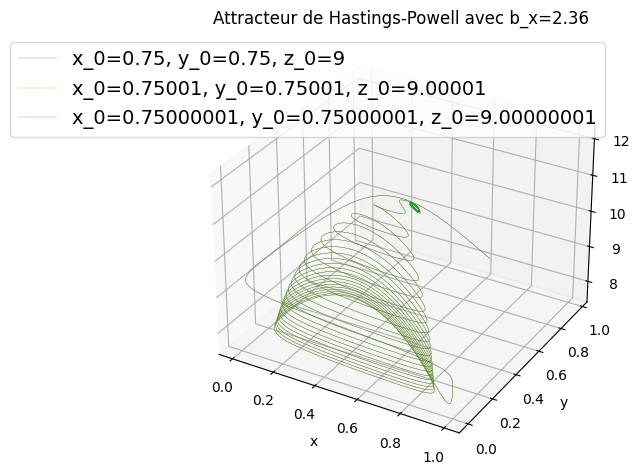

In [18]:
HastingsPowell_attracteur(X_0, X_0, Z_0, 2.36, 0.05)

Quelques valeures remarquables :

 $b_x$ < 2.36, on remarque que le système converge vers le point d'équilibre, plus précisemment, ce point est de type foyer attractif (qualitativement, la trajectoire tourne autour du point d'équilibre et converge vers lui).

 $b_x$ = 2.36, on remarque que la trajectoire tourne autour du point d'équilibre sans converger vers lui: on dit que le point est donc un centre.

$b_x$ = 2.55, la trajectoire fait deux fois plus de tour autour du point d'équilibre: on observe ce que l'on appelle un phénomène de doublement de période.

$b_x$ = 3, on remarque que la trajectoire varie grandiausement même pour des petites varations des conditions initiales: le système est donc chaotique.

## VII. Traçage de diagramme de bifurcation

Dans la partie précédente on a déduit que le comportement du système change selon $b_x$. Comment peut-on visulaliser l'ensemble de ces changements en fonction des valeurs de $b_x$? On trace ce qu'on appelle les diagrammes de bifurcations. Le traçage des diagrammes de bifucation consiste à prendre des sections contenant le point d'équilibre dans l'attracteur, pour beaucoup de valeurs du paramètre de bifurcation, et de traçer la figure $w$ en fonction de $b_x$ avec $w \in \{x,y,z\}$ 

Voilà le programme pour tracer le diagramme de bifurcation de x par rapport à $b_x$:

In [ ]:
def HastingsPowell_bifurcation_x_b_x(x_0, y_0, z_0, h):

    bifurcation, xbifurcation, zbifurcation,  b_xbifurcation = [],  [],  [], []
    B_x = linspace(2,3,10000) # on prend 10000 valeur de b_x entre 2 et 3
    
    for b_x in B_x: # pour chaqu'une de ces valeurs...
        
        t,  x,  y,  z  =  solution_RK4(x_0, y_0, z_0, b_x, h) # on résoud le système
        ysection,  zsection,  vecteur,  section  =  [],  [],  [],  []
        
        for k in range(len(x)):
            vecteur.append([t[k],x[k],y[k],z[k]]) # on cré les vecteurs solution
        
        for i in vecteur:
            if abs(i[2]-0.141025641025641)  <=  0.0001  : # on cherche les vecteurs solutions appartenant à la section y = y^*
                bifurcation.append([i[0],i[1],i[2],i[3],b_x])


    for k in bifurcation: # on prend les coordonnées des vecteur appartenent à la section d'équation y = y^*
        xbifurcation.append(k[1])
        zbifurcation.append(k[3])
        b_xbifurcation.append(k[4])

    plt.scatter(b_xbifurcation, xbifurcation, marker='.', s=1.5,  color='k') # on trace le diagramme
    plt.title("Diagramme de bifurcation représentant la variation de x en fonction de b_x")

    plt.xlabel('b_x')
    plt.ylabel('x')
    plt.show()

De la même manière on écrit la fonction qui trace le diagramme de bifurcation de y par rapport à $b_x$ et de z par rapport à $b_x$:

In [ ]:
def HastingsPowell_bifurcation_y_b_X(x_0, y_0, z_0, h):

    bifurcation, ybifurcation, zbifurcation,  b_xbifurcation = [],  [],  [], []
    B_x = linspace(2,3,10000)
 
    for b_x in B_x:
        
        t,  x,  y,  z  =  solution_RK4(x_0, y_0, z_0, b_x, h)
        xsection,  zsection,  vecteur,  section  =  [],  [],  [],  []
        
        for k in range(len(x)):
            vecteur.append([t[k],x[k],y[k],z[k]])
        
        for i in vecteur:
            if abs(i[1]-0.7847461517110025)  <=  0.00001  :
                bifurcation.append([i[0],i[1],i[2],i[3],b_x])

    for k in bifurcation:
        ybifurcation.append(k[2])
        zbifurcation.append(k[3])
        b_xbifurcation.append(k[4])

    plt.scatter(b_xbifurcation, ybifurcation, marker='.',s=1.5, color='k',)
    plt.title("Diagramme de bifurcation représentant la variation de y en fonction de b_x")

    plt.xlabel('b_x')
    plt.ylabel('y')
    plt.show()
    
def HastingsPowell_bifurcation_z_b_x(x_0, y_0, z_0, h):

    bifurcation, zbifurcation, xbifurcation,  b_xbifurcation = [],  [],  [], []
    B_x = linspace(2,3,10000)
   
    for b_x in B_x:
        
        t,  x,  y,  z  =  solution_RK4(x_0, y_0, z_0, b_x, h)
        xsection,  zsection,  vecteur,  section  =  [],  [],  [],  []
        
        for k in range(len(x)):
            vecteur.append([t[k],x[k],y[k],z[k]])
        
        for i in vecteur:
            if abs(i[1]-0.74)  <=  0.001  :
                bifurcation.append([i[0],i[1],i[2],i[3],b_x])

    for k in bifurcation:
        xbifurcation.append(k[1])
        zbifurcation.append(k[3])
        b1bifurcation.append(k[4])

    plt.scatter(b_xbifurcation, zbifurcation, marker='.',s=1.5, color='k')
    plt.title("Diagramme de bifurcation représentant la variation de z en fonction de b_x")

    plt.xlabel('b_x')
    plt.ylabel('z')
    plt.show()

In [ ]:
x_0, y_0, z_0 = 0.75, 0.3, 9

HastingsPowell_bifurcation_x_b_x(x_0, y_0, z_0, 0.5)
HastingsPowell_bifurcation_y_b_x(x_0, y_0, z_0, 0.5)
HastingsPowell_bifurcation_z_b_x(x_0, y_0, z_0, 0.5)

Ces programmes prennent beaucoup de temps pour s'exécuter, il faut être passion :)

## VIII. Comparaison avec les données réelles

Pendant les années 80 et 90, J. P. Pelletier et G. Balvay, deux chercheurs, s'interressent à l'étude de la vie microscopique du lac Léman. Ils prélèvent ainsi les effectifs de planctons herbivores, de nano phytoplanctons et du reste des espèces de phytoplanctons dans le lac. On suppose ainsi que X soit le nombre de planctons herbivores, Y celui de nano phytoplanctons et Z celui du reste des phytoplanctons dans le milieu. On comparera dans cette partie les valeurs prélevées par J. P. Pelletier et G. Balvay avec celles obtenues dans le système de Hastings-Powell

On commence par noter les listes des données réelles:

In [19]:
V_x=[50,50,250,250,150,600,400,1000,3000,1400,1900,500,350,600,400,1600,2100,800,900,200,50]
V_y=[50,50,70,100,500,2300,1250,1100,150,650,500,400,300,400,400,1250,400,400,200,300,100]
V_z=[200,100,300,600,750,3500,1400,1200,300,800,1000,1500,2200,1500,800,800,250,400,200]

On trace maintenant les figures présentant les données réelles et le modèle:

In [20]:
def HastingsPowell_plotx(x_0, y_0, z_0, b_x, h):
    
    t, x, y, z = solution_RK4(x_0, y_0, z_0, b_x, h) #on résoud le système
    
    L=linspace(0,100,21)
    nV_x=[k/4500 for k in V_x] # on prend 4500 comme effectif maximal de la population X (ce nombre été choisit de manière que le modèle soit le plus proche aux valeurs réelles)
    plt.plot(L,nV_x, marker='o',label='nombre de zooplanctons')# on trace le graphe des valeurs réelles.
    
    plt.plot([k+20 for k in t][0:int(60/h)],[n-0.2 for n in x][0:int(60/h)], label='x',color='r')# on adapte le modèle aux valeurs réelles par des transformations linéaires, et on trace la figure
    
    plt.grid()
    plt.legend()
    plt.xlabel('temps ( 1 unité = 3.5 jours )')
    plt.ylabel('''population x sur nombre maximal d'individus''')
    plt.title('Evolution des populations de proies au cours du temps')
    plt.show()
    
def HastingsPowell_ploty(x_0, y_0, z_0, b_x, h):
    
    t, x, y, z = solution_RK4(x_0, y_0, z_0, b_x, h) #on résoud le système
    
    L=linspace(0,100,21)
    nV_y=[k/5500 for k in V_y]# on prend 5500 comme effectif maximal de la population Y (ce nombre été choisit de manière que le modèle soit le plus proche aux valeurs réelles)
    plt.plot(L,nV_y, marker='o',label='nombre de nano phytoplanctons')# on trace le graphe des valeurs réelles.
    
    plt.plot([k+22 for k in t][0:int(60/h)],y[0:int(60/h)], label='y',color='r')# on adapte le modèle aux valeurs réelles par des transformations linéaires, et on trace la figure
    
    plt.grid()
    plt.legend()
    plt.xlabel('temps ( 1 unité = 3.5 jours )')
    plt.ylabel('''population y sur nombre maximal d'individus''')
    plt.title('Evolution de population de prédateurs au cours du temps')
    plt.show()
    
def HastingsPowell_plotz(x_0, y_0, z_0, b_x, h):
    
    t, x, y, z = solution_RK4(x_0, y_0, z_0, b_x, h) #on résoud le système 
    
    L=linspace(0,100,19)
    nV_z=[k/4000 for k in V_z]# on prend 4000 comme effectif maximal de la population Z (ce nombre été choisit de manière que le modèle soit le plus proche aux valeurs réelles)
    plt.plot(L,nV_z, marker='o',label='nombre total de phytoplanctons')# on trace le graphe des valeurs réelles.
    
    plt.plot([m-3 for m in t][int(20/h):int(100/h)],[y[k]+z[k]/3 -3 for k in range(len(z))][int(20/h):int(100/h)], label='z+y',color='r')# on adapte le modèle aux valeurs réelles par des transformations linéaires, et on trace la figure
    
    plt.grid()
    plt.legend()
    plt.xlabel('temps ( 1 unité = 3.5 jours )')
    plt.ylabel('''population y+z sur nombre maximal d'individus''')
    plt.title('Evolution des populations de phytoplanctons au cours du temps')
    plt.show()

Il faut tourner ces programmes avant de faire tourner les commandes suivantes qui donnent les graphes:

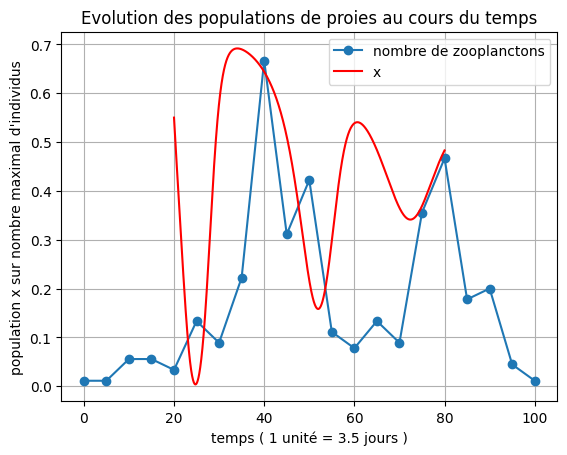

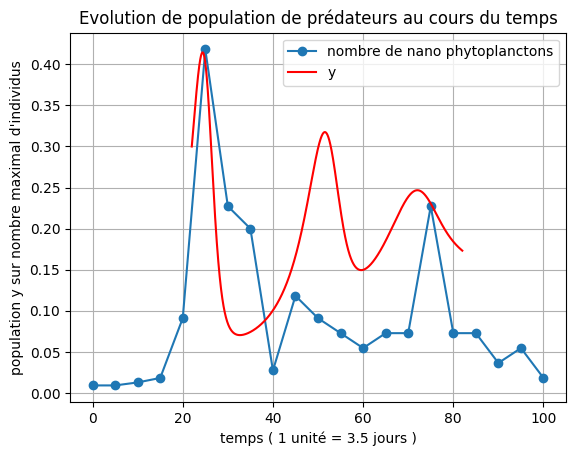

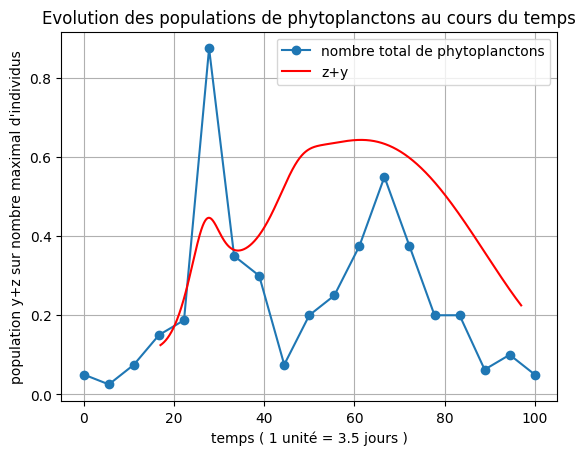

In [21]:
x_0, y_0, z_0 = 0.75, 0.3, 9

HastingsPowell_plotx(x_0, y_0, z_0, 2.9, 0.005)
HastingsPowell_ploty(x_0, y_0, z_0, 2.9, 0.005)
HastingsPowell_plotz(x_0, y_0, z_0, 2.9, 0.005)

Ensuite on écrit la fonction ```corrélation``` qui calcule les coefficients de corrélation des trois espèces.

In [30]:
def correlation(x_0, y_0, z_0, b_x, h):
    
    t, x, y, z = solution_RK4(x_0, y_0, z_0, b_x, h)
    
    # Listes des valeurs réelles
    nV_x=[k/4500 for k in V_x]
    nV_y=[k/5500 for k in V_y]
    nV_z=[k/4000 for k in V_z]
    
    # Adaptations du modèle aux valeurs implémentées dans les programmes précédents
    L_1 = [n-0.2 for n in x][20:int(60/h)+21]
    L_2 = y[22:int(60/h)+23]
    L_3 = [y[k]+z[k]/3 -3 for k in range(len(z))][int(20/h):int(100/h)]
    
    # Moyennes des listes définis précédemment
    M_x ,M_y, M_z = sum(L_1)/len(L_1), sum(L_2)/len(L_2), sum(L_3)/len(L_3)
    Mv_x, Mv_y, Mv_z = sum(nV_x)/len(nV_x), sum(nV_y)/len(nV_y), sum(nV_z)/len(nV_z)
    
    # Initialisation des différentes sommes
    S_x, S_y, S_z = 0, 0, 0
    S1x, S1y, S1z = 0, 0, 0
    SDx, SDy, SDz = 0, 0, 0
    
    # Calcul des sommes en suivant les diagrammes traçées précédemment
    for k in range(13):
        S_x+=(L_1[int((k*100)/19)]-M_x)*(nV_x[k+5]-Mv_x)
        SDx+=(nV_x[k+5]-Mv_x)**2
        S1x+=(L_1[int((k*100)/19)]-M_x)**2
        
    for k in range(1,12):
        S_y+=(L_2[int((k*100)/19)-2]-M_y)*(nV_y[k+5]-Mv_y)
        SDy+=(nV_y[k+5]-Mv_y)**2
        S1y+=(L_2[int((k*100)/19)-2]-M_y)**2
    
    for k in range(15):
        S_z+=(L_3[int((k*100)/19)]-M_z)*(nV_z[k+4]-Mv_z)
        SDz+=(nV_z[k+4]-Mv_z)**2
        S1z+=(L_3[int((k*100)/19)]-M_z)**2
    
    return S_x/(sqrt(S1x)*sqrt(SDx)), S_y/(sqrt(S1y)*sqrt(SDy)), S_z/(sqrt(S1z)*sqrt(SDz))

In [31]:
correlation(x_0, y_0, z_0, 2.9, 0.005)

(0.38316464408592144, 0.24652592126028847, -0.20065657676897308)